In [ ]:
""" Integrate the human stuff with the monkey stuff into the same modeling pipeline
"""


In [4]:
%load_ext autoreload
%autoreload 2

from analysis.getModelHumanDists import * 
from analysis.modelAnalyses import *
from analysis.importDrawgood import *
from analysis.compareModelHumanGood import *
from pythonlib.drawmodel.analysis import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# 1) Extract model parses
ECTRAIN="S12.10.test5"
DAT = loadCheckpoint(trainset=ECTRAIN, loadparse=True, suppressPrint=True, loadbehavior=False)

Loading dreamcoder checkpoint
Loading dreamcoder tasks
DRAW TASK training set: S12
DO SHAPING: False
training task names:
['S12_13_shaping_0', 'S12_13_shaping_1', 'S12_13_shaping_2', 'S12_13_shaping_3', 'S12_13_shaping_4', 'S12_13_shaping_5', 'S12_13_shaping_6', 'S12_13_shaping_7', 'S12_13_shaping_8', 'S12_13_shaping_9', 'S12_13_shaping_10', 'S12_1', 'S12_5', 'S12_8', 'S12_10', 'S12_32', 'S12_34', 'S12_38', 'S12_20', 'S12_39', 'S12_57', 'S12_79', 'S12_113', 'S12_124', 'S12_126', 'S12_133', 'S12_147', 'S12_155', 'S12_163', 'S12_200', 'S12_214', 'S12_31', 'S12_52', 'S12_55', 'S12_70', 'S12_129', 'S12_139', 'S12_141', 'S12_148', 'S12_207', 'S12_222', 'S12_224', 'S12_229', 'S12_233', 'S12_235', 'S12_243', 'S12_246']
test tasks:
['S12_13_test_1', 'S12_13_test_2', 'S12_13_test_4', 'S12_13_test_5', 'S12_13_test_6', 'S12_13_test_7', 'S12_13_test_8', 'S12_13_test_9', 'S12_13_test_10', 'S12_13_test_11', 'S12_13_test_12', 'S12_132', 'S12_201', 'S12_220', 'S12_247', 'S13_182', 'S13_217', 'S13_219'

In [8]:
stimlist = DATgetSolvedStim(DAT, onlyifhasdatflat=True, test_only=True)

REMOVING SHAPING STIMULI (THOSE HUMANS WERE NOT GIVEN) [wil even remove things like S9_shaping_5]
removing, since I think is shaping: S12_13_shaping_0
removing, since I think is shaping: S12_13_shaping_1
removing, since I think is shaping: S12_13_shaping_2
removing, since I think is shaping: S12_13_shaping_3
removing, since I think is shaping: S12_13_shaping_4
removing, since I think is shaping: S12_13_shaping_5
removing, since I think is shaping: S12_13_shaping_6
removing, since I think is shaping: S12_13_shaping_7
removing, since I think is shaping: S12_13_shaping_8
removing, since I think is shaping: S12_13_shaping_9
removing, since I think is shaping: S12_13_shaping_10


In [ ]:
for s in stimlist:
    datflat = DATloadDatFlat(DAT, s)
    print(len(datflat))


In [ ]:
datsegs = DATloadDatSeg(DAT, stimname)
datflat = DATloadDatFlat(DAT, s)
datseg = getSegmentation(datflat, unique_codes=True, dosplits=True, removebadstrokes=True, removeLongVertLine=REMOVELL) 

# 2) Prior: motor efficiency (redo this using continuous parameters?)


# 3) Likelihood: redo this using continouos parametres?

In [ ]:
# human
DAT["datflat_hu"] = getFlatData(DAT["datall_human"])
DAT["datseg_hu"] = getSegmentation(DAT["datflat_hu"], unique_codes=True, dosplits=True, removeLongVertLine=REMOVELL)                                      
# model
datseg = getSegmentation(datflat, unique_codes=True, dosplits=True, removebadstrokes=True, removeLongVertLine=REMOVELL) # get datseg


In [10]:
from drawgood.experiments.preprocess import loadPreprocessedData, getFlatData
EXPT = "2.4"
datall, savedir = loadPreprocessedData(EXPT)
datflat = getFlatData(datall)


Loading preprocessed data (datall): /data1/code/python/ec/data/datall_2.4.pickle
Loading preprocessed data (datall): /home/lucast4/drawgood/experiments/data/datall_2.4.pickle
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_8.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_1.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_5.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_38.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_10.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_32.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_34.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_79.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_57.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_124.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_126.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_214.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_163.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_200.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_113.png
CLEANING UP, skipping: A28J7H4TH29DC3 - S12_133.png
CLEAN

In [12]:
# ############## [GOOD]
# one object for each human and each model.
# from drawgood.experiments.utils import strokes2nparray
from pythonlib.drawmodel.strokePlots import plotDatStrokes
from pythonlib.drawmodel.segmentation import getSegmentation
from pythonlib.drawmodel.program import program2strokesWrapper
from pythonlib.tools.stroketools import strokesInterpolate

In [77]:
human = "AI36LV7AATYWF"
# human = "AIK9IRPT4M848"
Ninterp = 15
trainset = "S12"
# each stim corresponds to one trial
SINGLE_STIM_TEMP = "S12_13_test_1"

# -- load all tasks
alltasks, testtasks, _, _ = makeSupervisedTasks(trainset=trainset, doshaping=True)

strokes_all_beh = []
datsegs_all_beh = []
tasks = []
for stim in stimlist:
    if stim!=SINGLE_STIM_TEMP:
        continue
        
    # get human behavior as strokes
    datthis = [d for d in datflat if d["workerID"]==human and d["stimname"]==f"{stim}.png"]
#     assert len(datthis)==1
#     strokes = datthis[0]["trialstrokes"]
#     strokes = strokes2nparray(strokes, recenter_and_flip=True, combinestrokes=False, 
#                               sec_rel_first_stroke=True, sec_rel_task_onset=True)
    
    # process data to strokes + other things.
    datseg = getSegmentation(datthis, unique_codes=True, dosplits=True, 
                             removebadstrokes=True, removeLongVertLine=False, include_npstrokes=True)
    strokes = [d["stroke"] for d in datseg[0]]
    
    # ---- Insert into Dataset
    strokes_all_beh.append(strokes)
    datsegs_all_beh.append(datseg)
    
    # === task
    if False:
        T = DATgetTask(stim, DAT)[0]
    else:
        # this better since doesnt need to refer to DC model
        T = [t for t in testtasks if t.name==stim]
        assert len(T)==1, "didnt find task"
        T = T[0]
    prog = T.strokes
    
    # 2) convert to strokes
    if False:
        print(prog[0])
        strokes = program2strokes(prog) # appends fake timesteps
        strokes = strokesInterpolate(strokes, N=Ninterp) # do interpolation
        print(strokes[0])
    else:
#         print(prog[0])
#         fakeTimesteps(prog, None, "in_order")
#         plt.figure()
#         ax = plt.subplot(1,1,1)
#         plotDatStrokes(prog, ax=ax, plotver="strokes")
        dflat, dseg = program2strokesWrapper([prog], get_datsegs=True)
    
    if False:
        ax = plt.subplot(1,1,1)
        plotDatStrokes(strokes, ax=ax, plotver='strokes')

    tasks.append({
        "strokes":dflat[0]["trialstrokes"],
        "datseg":dseg[0],
        "fixpos":[],
        "str":stim})    
    
dset = Dataset(strokes_all_beh, tasks)

dset1 = dset

DRAW TASK training set: S12
DO SHAPING: True
INCLUDING SHAPING STIMULI
training task names:
['shaping_0', 'shaping_1', 'shaping_2', 'shaping_3', 'shaping_4', 'shaping_5', 'shaping_6', 'shaping_7', 'shaping_8', 'S12_13_shaping_0', 'S12_13_shaping_1', 'S12_13_shaping_2', 'S12_13_shaping_3', 'S12_13_shaping_4', 'S12_13_shaping_5', 'S12_13_shaping_6', 'S12_13_shaping_7', 'S12_13_shaping_8', 'S12_13_shaping_9', 'S12_13_shaping_10', 'S12_1', 'S12_5', 'S12_8', 'S12_10', 'S12_32', 'S12_34', 'S12_38', 'S12_20', 'S12_39', 'S12_57', 'S12_79', 'S12_113', 'S12_124', 'S12_126', 'S12_133', 'S12_147', 'S12_155', 'S12_163', 'S12_200', 'S12_214', 'S12_31', 'S12_52', 'S12_55', 'S12_70', 'S12_129', 'S12_139', 'S12_141', 'S12_148', 'S12_207', 'S12_222', 'S12_224', 'S12_229', 'S12_233', 'S12_235', 'S12_243', 'S12_246']
test tasks:
['S12_13_test_1', 'S12_13_test_2', 'S12_13_test_4', 'S12_13_test_5', 'S12_13_test_6', 'S12_13_test_7', 'S12_13_test_8', 'S12_13_test_9', 'S12_13_test_10', 'S12_13_test_11', 'S12_1

In [78]:
# human = "AI36LV7AATYWF"
human = "AIK9IRPT4M848"
Ninterp = 15
trainset = "S12"
# each stim corresponds to one trial
SINGLE_STIM_TEMP = "S12_13_test_1"

# -- load all tasks
alltasks, testtasks, _, _ = makeSupervisedTasks(trainset=trainset, doshaping=True)

strokes_all_beh = []
datsegs_all_beh = []
tasks = []
for stim in stimlist:
    if stim!=SINGLE_STIM_TEMP:
        continue
        
    # get human behavior as strokes
    datthis = [d for d in datflat if d["workerID"]==human and d["stimname"]==f"{stim}.png"]
#     assert len(datthis)==1
#     strokes = datthis[0]["trialstrokes"]
#     strokes = strokes2nparray(strokes, recenter_and_flip=True, combinestrokes=False, 
#                               sec_rel_first_stroke=True, sec_rel_task_onset=True)
    
    # process data to strokes + other things.
    datseg = getSegmentation(datthis, unique_codes=True, dosplits=True, 
                             removebadstrokes=True, removeLongVertLine=False, include_npstrokes=True)
    strokes = [d["stroke"] for d in datseg[0]]
    
    # ---- Insert into Dataset
    strokes_all_beh.append(strokes)
    datsegs_all_beh.append(datseg)
    
    # === task
    if False:
        T = DATgetTask(stim, DAT)[0]
    else:
        # this better since doesnt need to refer to DC model
        T = [t for t in testtasks if t.name==stim]
        assert len(T)==1, "didnt find task"
        T = T[0]
    prog = T.strokes
    
    # 2) convert to strokes
    if False:
        print(prog[0])
        strokes = program2strokes(prog) # appends fake timesteps
        strokes = strokesInterpolate(strokes, N=Ninterp) # do interpolation
        print(strokes[0])
    else:
#         print(prog[0])
#         fakeTimesteps(prog, None, "in_order")
#         plt.figure()
#         ax = plt.subplot(1,1,1)
#         plotDatStrokes(prog, ax=ax, plotver="strokes")
        dflat, dseg = program2strokesWrapper([prog], get_datsegs=True)
    
    if False:
        ax = plt.subplot(1,1,1)
        plotDatStrokes(strokes, ax=ax, plotver='strokes')

    tasks.append({
        "strokes":dflat[0]["trialstrokes"],
        "datseg":dseg[0],
        "fixpos":[],
        "str":stim})    
    
dset = Dataset(strokes_all_beh, tasks)
dset2 = dset

DRAW TASK training set: S12
DO SHAPING: True
INCLUDING SHAPING STIMULI
training task names:
['shaping_0', 'shaping_1', 'shaping_2', 'shaping_3', 'shaping_4', 'shaping_5', 'shaping_6', 'shaping_7', 'shaping_8', 'S12_13_shaping_0', 'S12_13_shaping_1', 'S12_13_shaping_2', 'S12_13_shaping_3', 'S12_13_shaping_4', 'S12_13_shaping_5', 'S12_13_shaping_6', 'S12_13_shaping_7', 'S12_13_shaping_8', 'S12_13_shaping_9', 'S12_13_shaping_10', 'S12_1', 'S12_5', 'S12_8', 'S12_10', 'S12_32', 'S12_34', 'S12_38', 'S12_20', 'S12_39', 'S12_57', 'S12_79', 'S12_113', 'S12_124', 'S12_126', 'S12_133', 'S12_147', 'S12_155', 'S12_163', 'S12_200', 'S12_214', 'S12_31', 'S12_52', 'S12_55', 'S12_70', 'S12_129', 'S12_139', 'S12_141', 'S12_148', 'S12_207', 'S12_222', 'S12_224', 'S12_229', 'S12_233', 'S12_235', 'S12_243', 'S12_246']
test tasks:
['S12_13_test_1', 'S12_13_test_2', 'S12_13_test_4', 'S12_13_test_5', 'S12_13_test_6', 'S12_13_test_7', 'S12_13_test_8', 'S12_13_test_9', 'S12_13_test_10', 'S12_13_test_11', 'S12_1

In [79]:
# === get parses
# this goes in model code
mod = Model("test", makePriorFunction()[0], makeLikeliFunction(), use_presaved_parses=True, 
            parses=DAT["parses"])
dset1.applyModel(mod, standardize_strokes=True)

mod = Model("test", makePriorFunction()[0], makeLikeliFunction(), use_presaved_parses=True, 
            parses=DAT["parses"])
dset2.applyModel(mod, standardize_strokes=True)

# === Include datseg for parses and behavior, and use that for prior model.

# === Compute likelihood using distance (align them first, e.g., units)


NOTE: should get parses in both directions [default for getParses()], since this distance function cares about the chron order.
64 parses found.
NOTE: should get parses in both directions [default for getParses()], since this distance function cares about the chron order.
64 parses found.


NOTE: the x and y lims are hacky, should change
NOTE: the x and y lims are hacky, should change


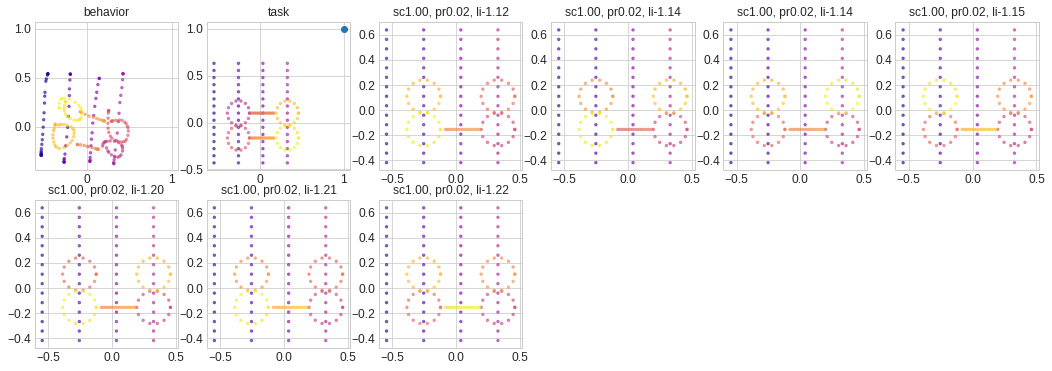

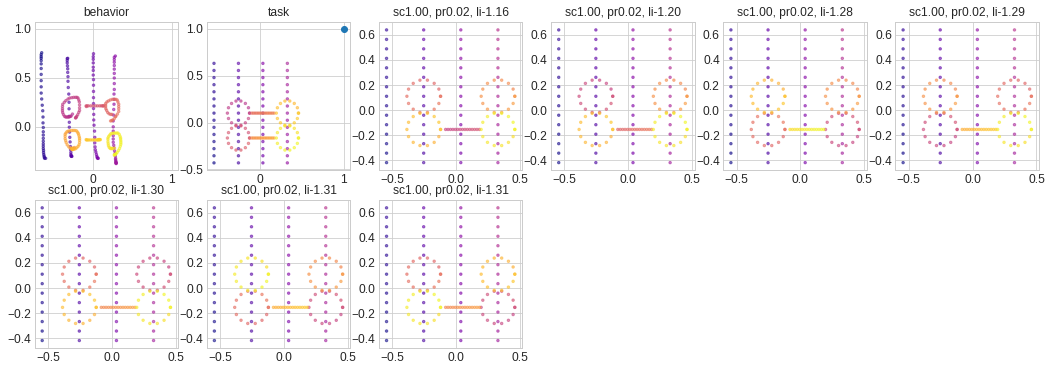

In [80]:
%matplotlib inline
# TODO:
# (1) Plot parses, task, and behavior 
dset1.plotExampleTrial(0, max_parses=7, sort_by_likeli=True)
dset2.plotExampleTrial(0, max_parses=7, sort_by_likeli=True)

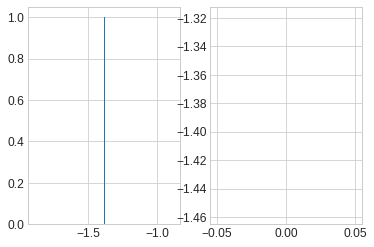

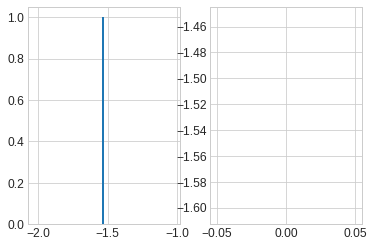

In [81]:
# (2) 
dset1.plotPosteriorHist()
dset2.plotPosteriorHist()

In [ ]:
from pythonlib.drawmodel.program import *
parses2datflat([prog], finalize_strokes=True)

In [ ]:
from drawgood.experiments.modelPlanning import Planner, getParamsAggregate, flattenSummary

# === extract Planner model

# ECTRAINlist = ["S12.10.test4", "S13.10.test4"]
# modelkind_list = ["parse", "randomperm"]
# ver="aggregate"
# randomsubset=10000 # if [], then will get all parses. if an int, then will
# # subsample without replacement.

# ===== Planner model to load
BATCHNAME = "191108"
EXPT = "2.4"

# ===== Params for current -rescoring
PLANVERDICT={
    "motor":['start', 'motor_dist', 'motor_dir'],
    "motorplusVH":['start', 'motor_dist', 'motor_dir', 'cog_vertchunker'],
    "full":['start', 'motor_dist', 'motor_dir', 'cog_primtype', 'cog_vertchunker', 'cog_vertchunker_LL']}

planver = "motor"
params_list = PLANVERDICT[planver]

# for planver, params_list in PLANVERDICT.items():
    ###################### RUN PREPROECESS
    # 1) load human-dc distances
#     distances_flat = loadMultDCHumanDistances(ECTRAINlist, modelkind_list, ver)
#     # 2) load DC data
#     DAT_all, workerlist, SAVEDIR = loadMultDCdata(ECTRAINlist)
#     SAVEDIRDAT = savedirDat(ECTRAINlist)
#     print("SAVING AT {}".format(SAVEDIRDAT))
#     # 3) add worker conditions
#     addWorkerCond(distances_flat, workerlist)
# 4) Load Planner data
print("LOADING planner model fit data")
Planner, summarydict_all, datall, savedir = loadPlannerData(EXPT, BATCHNAME)
# params = D.getParamsAggregate(D.flattenSummary(summarydict_all), returnnames=True)

# 5) Get Planner using mean data across subjects
print("Settuing up a planner object using previously fit params")
params = getParamsAggregate(flattenSummary(summarydict_all), returnnames=True, meanoverworkers=True)
planner = Planner(paramslist=params_list, handparams=getParamValues(params, params_list))


In [ ]:
planner.scoreMultTasks(datsegs_sub, getRawScore=True, returnAllScores=True)

In [ ]:
t = DATgetTask(stim, DAT)[0]
t.specialTask

In [ ]:
dir(DATgetTask(stim, DAT)[0])

In [ ]:
datflat[0]

In [ ]:
# put all into the model object

In [ ]:
## ==== VERSION 2 - LOAD ALL AT ONCE INTO MEMEORY, NOT PIECEMEITL
# 1) Load dreamcoder
# ECTRAINlist = ["S12.10.test4", "S13.10.test4"]
ECTRAINlist = ["S12.10.test5", "S13.10.test5"]
modelkind_list = ["parse", "randomperm"]
ver="aggregate"
use_withplannerscore=True

distances_flat, DAT_all, workerlist, SAVEDIR = loadMultDCHumanDistances(
    ECTRAINlist, modelkind_list, ver, use_withplannerscore)


In [ ]:

## integrate into 


In [ ]:
############# SUMMARIZE HUMAN-HUMAN DISTS

# 1) Collect previously computed human-human distances in a list of dicts (is a full table)
outdict = getHumanHumanDists()

# 2) Collect all distances, meaned over "other humans" grouped by condition.
humanlist = [w["workerID"] for w in workerlist]
stimlist = [t.name for t in DAT_all[0]["testtasks"]]

outdict_summary = []
for human in humanlist:
    print(human)
    cond = extractHumanCond(human, workerlist)
    # - each human gets one value for each cond
    dists_bycond = []
    for cond_other in [0,1]:
        for stim in stimlist:    
            outdict_summary.append({
                "human":human,
                "cond_human":cond,
                "cond_other":cond_other,
                "stim":stim,
                "dist_mean":np.mean([o["dist"] for o in outdict if o["human1"]==human and extractHumanCond(o["human2"], workerlist)==cond_other
                 and o["task"]==stim])
            })
            

In [ ]:
# 3) Get ready for plotting by converting to pandas and aggregating over stim
# i.e. first aggregated over other people, and then over stims - shouldn't matter since is ballanced.

import pandas as pd
from pythonlib.tools import pandastools as pdt

df = pd.DataFrame(outdict_summary)
df = pdt.aggregGeneral(df, ["human", "cond_other", "cond_human"], ["dist_mean"])
df = pdt.applyFunctionToAllRows(df, F=lambda x: x["cond_human"]==x["cond_other"], newcolname="cond_aligned")

# --- get aligned minus notaligned (df --> dict --> df... is dumb).
df_dict = df.to_dict("records")
df_dict_minused = []
for human in humanlist:
    d1 = [d["dist_mean"] for d in df_dict if d["human"]==human and d["cond_aligned"]==True][0]
    d2 = [d["dist_mean"] for d in df_dict if d["human"]==human and d["cond_aligned"]==False][0]
    
    df_dict_minused.append({
        "human":human,
        "dist_aligned_minus_not":d1-d2,
    })
df_aligned = pd.DataFrame(df_dict_minused)
    

In [ ]:
SAVEDIR = f"analysis/summaryfigs/acrossexpt/ecS12.10.test5_S13.10.test5-dg2.4_2.4/closer_analysis/notebook_comparing_human_model_parses"
savedir = f"{SAVEDIR}/human_human_distances"
import os
os.makedirs(savedir, exist_ok=True)

In [ ]:
import seaborn as sns
from pythonlib.tools.snstools import rotateLabel

ax = sns.catplot(x="human", y="dist_mean", hue="cond_other", col="cond_human", data=df, aspect=2, height=4)
rotateLabel(ax)
ax.savefig(f"{savedir}/overview_meanOverTeststimAndOtherhuman_byhuman.pdf")
                                                                
ax = sns.catplot(x="cond_other", y="dist_mean", hue="cond_other", col="cond_human", data=df)
ax.savefig(f"{savedir}/overview_meanOverTeststimAndOtherhuman_aggreg.pdf")

ax = sns.catplot(x="cond_aligned", y="dist_mean", data=df, ci=68, kind="point")
ax.savefig(f"{savedir}/overview_meanbyaligned.pdf")

ax = sns.catplot(y="dist_aligned_minus_not", data=df_aligned, ci=68, kind="point")
plt.ylim([0, -0.04])
ax.savefig(f"{savedir}/overview_grandmean.pdf")





In [ ]:
## SCRATCH
# load model-human distances preprocessed
DATloadModelHuDist(DAT_all[0], "S12_1", "A2VLTSW6CXIUMR", "aggregate", True)

# load processed datsegs (segmented)
DATloadDatSeg(DAT_all[0], "S12_1")[0]

# load stroke data
DATloadDatFlat(DAT_all[0], "S12_1")[0]